In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy.spatial.distance import euclidean
from scipy.special import expit
import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.simulation import simulate_raw, SourceSimulator
from mne.datasets import sample
import pyvista as pv
from pyvista import themes
from mne.simulation.metrics import region_localization_error

# Set random state for reproducibility
random_state = 42

# Load spike data
spike_data = scipy.io.loadmat('spike.mat')
source_time_series = spike_data['spike'].squeeze()

# Cortex Signal Simmulation

In [2]:
# Load dataset information
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"
evoked_fname = data_path / "MEG" / subject / "sample_audvis-ave.fif"
info = mne.io.read_info(evoked_fname)
tstep = 1.0 / info["sfreq"]

# Load forward solution and source space
fwd_fname = data_path / "MEG" / subject / "sample_audvis-meg-eeg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /Users/diana/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transform

In [3]:
import os.path as op
subjects_dir = op.join(data_path, 'subjects')

In [4]:
model = mne.make_bem_model(subject='sample', ico=4, conductivity=[0.3, 0.006, 0.3],
                               subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    3.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    3.5 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        

In [16]:
src = mne.setup_source_space('sample', spacing='ico4',
                                 subjects_dir=subjects_dir)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/diana/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/155407 selected to source space (ico = 4)

Loading /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/156866 selected to sou

In [5]:
fig = mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir,
                 brain_surfaces='white', orientation='coronal', src=src)

Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


ValueError: Source space must be in MRI coordinates, got head

In [7]:
# Simulation parameters
n_events = 50
events = np.zeros((n_events, 3), int)
events[:, 0] = 200 * np.arange(n_events)
events[:, 2] = 1
snrs = np.linspace(0.02, 1.0, 20)

# Function to add noise with specified SNR
def add_noise_with_snr(raw, snr, random_state=None):
    raw_with_noise = raw.copy()
    data, _ = raw_with_noise[:]
    rms_signal = np.sqrt(np.mean(data ** 2, axis=1))
    np.random.seed(random_state)
    noise = np.random.normal(0, 1, data.shape)
    rms_noise = np.sqrt(np.mean(noise ** 2, axis=1))
    scaling_factor = rms_signal / (snr * rms_noise)
    noise = noise * scaling_factor[:, np.newaxis]
    data_with_noise = data + noise
    raw_with_noise._data = data_with_noise
    return raw_with_noise

def plot_violin_plot(std_dict):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=list(std_dict.values()), inner="point", ax=ax)
    ax.set_xticks(np.arange(len(std_dict)))
    ax.set_xticklabels([f"SNR={snr:.2f}" for snr in std_dict.keys()])
    ax.set_title("Violin Plot of Standard Deviation for Signal in Each SNR")
    ax.set_ylabel("Standard Deviation")
    plt.savefig('violin_plot_std.png')
    plt.show()

def plot_max_amplitude(stc_est, subject, subjects_dir):
    max_amp = np.max(stc_est.data)
    stc_est.plot(
        subject=subject, 
        subjects_dir=subjects_dir, 
        hemi='both', 
        initial_time=0, 
        time_viewer=True, 
        colormap="hot", 
        clim=dict(kind='value', pos_lims=[0, max_amp*0.5, max_amp])
    )

### Custome Localisation Error 

## UPD. Check how to estimate true region loclaisation error (lowes, highes or avg)

In [6]:
from scipy.spatial.distance import euclidean
import numpy as np

def custom_localization_error(stc_true, stc_est, subject, subjects_dir):
    """
    Calculate custom localization error (LE) in mm with handling of negative values.
    
    Parameters:
    - stc_true: SourceEstimate, true source estimate.
    - stc_est: SourceEstimate, estimated source estimate.
    - subject: str, subject name.
    - subjects_dir: str, path to subjects directory.
    
    Returns:
    - error_mm: float, localization error in millimeters.
    """
    try:
        # Remove negative values by setting them to zero before computing the center of mass
        stc_true_data = np.maximum(stc_true.data, 0)
        stc_est_data = np.maximum(stc_est.data, 0)

        # Create new SourceEstimates with non-negative data
        stc_true_nonneg = mne.SourceEstimate(stc_true_data, stc_true.vertices, stc_true.tmin, stc_true.tstep)
        stc_est_nonneg = mne.SourceEstimate(stc_est_data, stc_est.vertices, stc_est.tmin, stc_est.tstep)

        # Compute the center of mass for both hemispheres for the true and estimated source
        true_coords_lh = stc_true_nonneg.center_of_mass(subject=subject, hemi=0, subjects_dir=subjects_dir)
        true_coords_rh = stc_true_nonneg.center_of_mass(subject=subject, hemi=1, subjects_dir=subjects_dir)
        est_coords_lh = stc_est_nonneg.center_of_mass(subject=subject, hemi=0, subjects_dir=subjects_dir)
        est_coords_rh = stc_est_nonneg.center_of_mass(subject=subject, hemi=1, subjects_dir=subjects_dir)

        # Check if any coordinates are None (if the center of mass couldn't be computed)
        if true_coords_lh is None or true_coords_rh is None or est_coords_lh is None or est_coords_rh is None:
            print("Center of mass could not be computed for one of the hemispheres.")
            return np.nan

        # Convert coordinates from meters to millimeters (if necessary)
        true_coords_lh = np.array(true_coords_lh) / 1000  # Convert from santimeters to mm
        true_coords_rh = np.array(true_coords_rh) / 1000  # Convert from santimeters to mm
        est_coords_lh = np.array(est_coords_lh) / 1000    # Convert from santimeters to mm
        est_coords_rh = np.array(est_coords_rh) / 1000    # Convert from santimeters to mm

        # Calculate Euclidean distance between true and estimated sources for each hemisphere
        distance_lh = euclidean(true_coords_lh, est_coords_lh) if true_coords_lh is not None and est_coords_lh is not None else np.nan
        distance_rh = euclidean(true_coords_rh, est_coords_rh) if true_coords_rh is not None and est_coords_rh is not None else np.nan

        # Print the coordinates for debugging
        print(f"True LH: {true_coords_lh}, Estimated LH: {est_coords_lh}, Distance LH: {distance_lh:.2f} mm")
        print(f"True RH: {true_coords_rh}, Estimated RH: {est_coords_rh}, Distance RH: {distance_rh:.2f} mm")

        # Average error in mm across both hemispheres (ignoring NaNs)
        error_mm = np.min([distance_lh, distance_rh])

        print(f"Localization Error (LH): {distance_lh:.2f} mm")
        print(f"Localization Error (RH): {distance_rh:.2f} mm")
        print(f"Average Localization Error: {error_mm:.2f} mm")

        return error_mm

    except ValueError as e:
        print(f"Error calculating localization error: {e}")
        return np.nan


In [ ]:
# Create directory to store simulated data
output_dir = "simulated_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dictionaries to store results
results_snr_rle_cortex = {snr: [] for snr in snrs}
std_snr_cortex = {snr: [] for snr in snrs}
results_snr_rle_custom_cortex = {snr: [] for snr in snrs}
mean_signals_snr_cortex = {snr: [] for snr in snrs}

pv.set_plot_theme(themes.DocumentTheme())

In [44]:
random_roi = np.random.choice(["parahippocampal-lh"])

In [45]:
random_roi

'parahippocampal-lh'

In [46]:
random_label = mne.read_labels_from_annot(subject, regexp=random_roi, subjects_dir=subjects_dir)[0]

Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot


In [47]:
random_label

<Label | sample, 'parahippocampal-lh', lh : 1434 vertices>

In [12]:
for snr in snrs:
    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    
    # Добавляем всплески в случайные ROI
    for _ in range(n_events):
        random_roi = np.random.choice(["caudalmiddlefrontal-lh", "middletemporal-lh"])
        random_label = mne.read_labels_from_annot(subject, regexp=random_roi, subjects_dir=subjects_dir)[0]
        source_simulator.add_data(random_label, source_time_series, events)
    
    # Симулируем raw данные
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
    raw = raw.pick_types(meg=True, eeg=False, stim=True, exclude='bads')
    cov = mne.make_ad_hoc_cov(raw.info)

    # Добавляем шум и создаем эпохи
    raw_with_noise = add_noise_with_snr(raw, snr, random_state=random_state)
    epochs = mne.Epochs(raw_with_noise, events, 1, tmin=0, tmax=0.2, baseline=None)
    evoked = epochs.average()

    # Создаем инверсионный оператор и оцениваем источник
    inv_method = "sLORETA"
    lambda2 = 1.0 / snr**2
    inverse_operator = make_inverse_operator(evoked.info, fwd, cov, loose="auto", depth=0.8, fixed=True)

    # Генерируем случайную 'истинную' оценку источника
    stc_true = mne.SourceEstimate(
        np.random.rand(len(src[0]['vertno']) + len(src[1]['vertno']), len(evoked.times)),
        vertices=[src[i]['vertno'] for i in range(len(src))],
        tmin=0, tstep=1.0 / info["sfreq"]
    )

    # Применяем инверсионное решение для оценки местоположений источников
    stc_est = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
    
    # Compute Region Localization Error (RLE)
    try:
        rle = region_localization_error(stc_true, stc_est, src, per_sample=False)
        rle_mm = 1 / rle 
        results_snr_rle_cortex[snr].append(rle_mm)
    except Exception as e:
        print(f"Error calculating RLE at SNR={snr}: {e}")
        results_snr_rle_cortex[snr].append(np.nan)
        
    # Compute custom Region Localization Error (RLE) using our function
    try:
        rle_custom_mm = custom_localization_error(stc_true, stc_est, subject, subjects_dir)
        results_snr_rle_custom_cortex[snr].append(rle_custom_mm)
        
        print(f"SNR={snr}: Average Custom RLE={rle_custom_mm:.2f} mm")
    
    except ValueError as e:
        print(f"Error calculating custom RLE at SNR={snr}: {e}")
        results_snr_rle_custom_cortex[snr].append(np.nan)

    std_signal = np.std(evoked.data, axis=0)
    std_snr_cortex[snr] = std_signal
    mean_signal = np.mean(evoked.data, axis=0)
    mean_signals_snr_cortex[snr] = mean_signal

    # Save data for later use
    file_name = f"{output_dir}/simulated_cortex_SNR_{snr:.1f}.fif"
    raw_with_noise.save(file_name, overwrite=True)
    
    # Max amp visualisation
    plot_max_amplitude(stc_est, subject, subjects_dir)

#     # Визуализируем истинные источники
#     stc_true.plot(subject=subject, subjects_dir=subjects_dir, title=f'True Source for SNR={snr}', hemi='both', initial_time=0, time_viewer=True)

#     # Визуализируем оцененные источники
#     stc_est.plot(subject=subject, subjects_dir=subjects_dir, title=f'Estimated Source for SNR={snr}', 
#                  hemi='both', views='lateral', smoothing_steps=5, time_viewer=True)

#     # Вычисляем центр масс и расстояние
#     try:
#         # Вычисляем центр масс для каждого полушария
#         true_coords_lh = stc_true.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         true_coords_rh = stc_true.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)
#         est_coords_lh = stc_est.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         est_coords_rh = stc_est.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)

#         # Вычисляем евклидово расстояние для каждого полушария
#         distance_lh = euclidean(true_coords_lh, est_coords_lh)
#         distance_rh = euclidean(true_coords_rh, est_coords_rh)

#         print(f"SNR={snr}: LH True Source={true_coords_lh}, LH Estimated Source={est_coords_lh}, LH Distance={distance_lh:.2f} mm")
#         print(f"SNR={snr}: RH True Source={true_coords_rh}, RH Estimated Source={est_coords_rh}, RH Distance={distance_rh:.2f} mm")

#     except ValueError as e:
#         print(f"Error calculating center of mass: {e}")

Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Using pyvistaqt 3d backend.


2025-03-15 23:26:35.723 python[10422:2410804] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-15 23:26:35.723 python[10422:2410804] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_0.9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_10422/1702179246.py:62: RuntimeWarning: This filename (/Users/diana/Documents/simulated_data/simulated_cortex_SNR_1.0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


In [14]:
# Save RLE metrics to CSV
metrics_data = [{'SNR': snr, 'RLE': np.mean(results_snr_rle_cortex[snr]), 'RLE Custom': np.mean(results_snr_rle_custom_cortex[snr])} for snr in snrs]
df_metrics = pd.DataFrame(metrics_data)
df_metrics.to_csv(f"{output_dir}/metrics_cortex_results_rle.csv", index=False)

# Calculate Standard Error (SE)
se_rle = {snr: np.std(results_snr_rle_cortex[snr]) / np.sqrt(len(results_snr_rle_cortex[snr])) for snr in snrs}

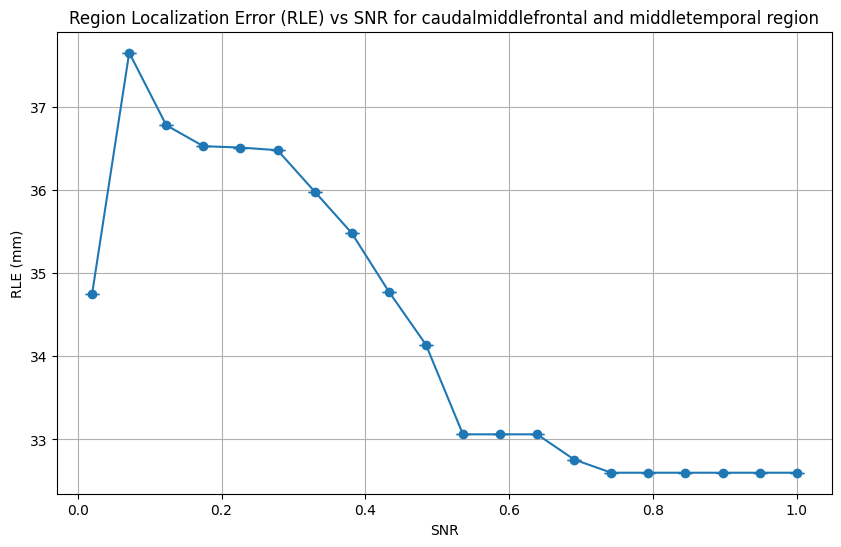

In [15]:
# Plot RLE vs SNR with SE
fig, ax = plt.subplots(figsize=(10, 6))
rle_means = [np.mean(results_snr_rle_cortex[snr]) for snr in snrs]
rle_se = [se_rle[snr] for snr in snrs]
ax.errorbar(snrs, rle_means, yerr=rle_se, fmt='-o', capsize=5)
ax.set_title('Region Localization Error (RLE) vs SNR for caudalmiddlefrontal and middletemporal region')
ax.set_ylabel('RLE (mm)')
ax.set_xlabel('SNR')
ax.grid(True)
plt.savefig('rle_vs_snr_with_se.png')
plt.show()

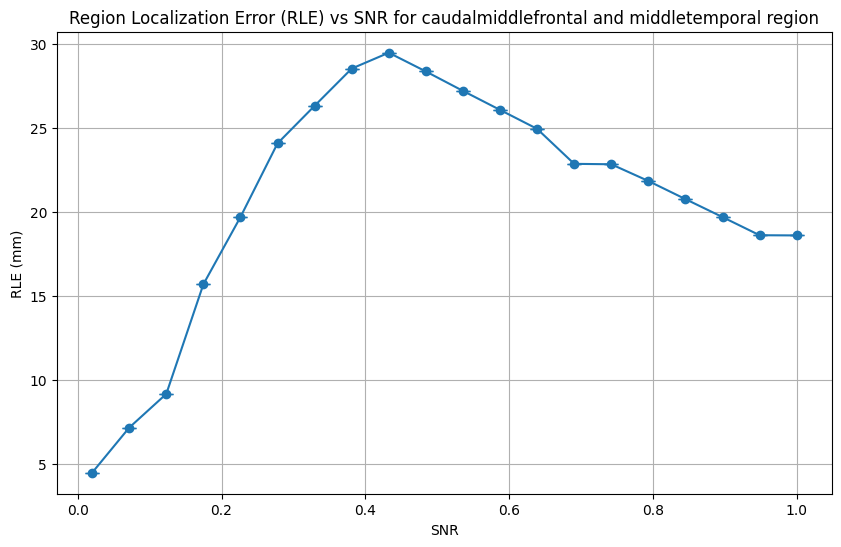

In [16]:
# Plot RLE vs SNR with SE
fig, ax = plt.subplots(figsize=(10, 6))
rle_means = [np.mean(results_snr_rle_custom_cortex[snr]) for snr in snrs]
rle_se = [se_rle[snr] for snr in snrs]
ax.errorbar(snrs, rle_means, yerr=rle_se, fmt='-o', capsize=5)
ax.set_title('Region Localization Error (RLE) vs SNR for caudalmiddlefrontal and middletemporal region')
ax.set_ylabel('RLE (mm)')
ax.set_xlabel('SNR')
ax.grid(True)
plt.savefig('rle_vs_snr_with_se.png')
plt.show()

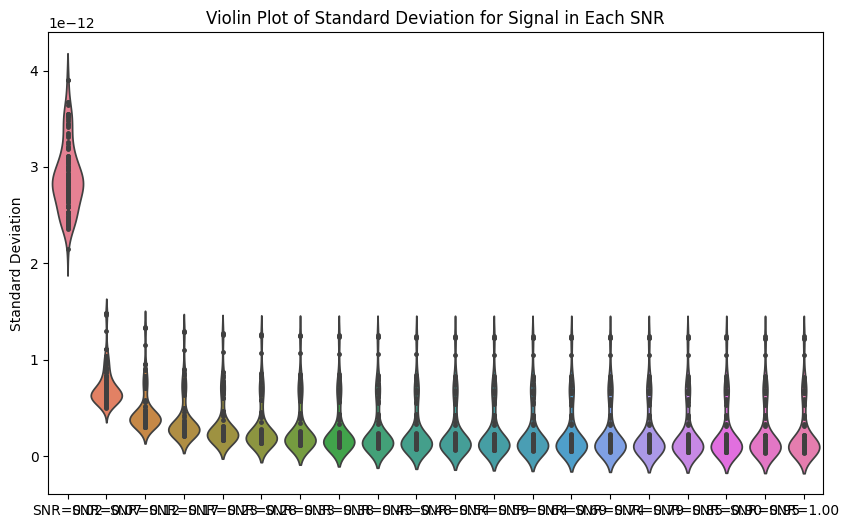

In [17]:
plot_violin_plot(std_snr_cortex)

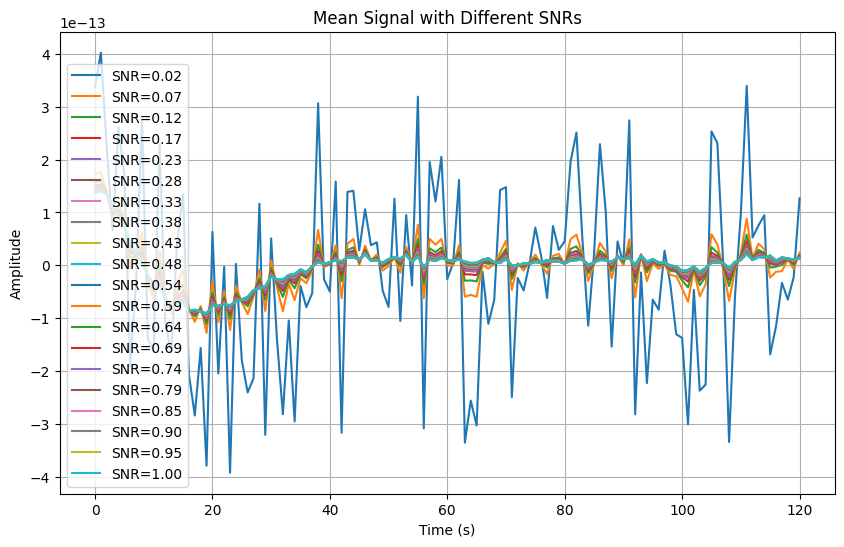

In [18]:
# Plot mean signal for different SNRs
fig, ax = plt.subplots(figsize=(10, 6))
for snr in snrs:
    ax.plot(mean_signals_snr_cortex[snr], label=f"SNR={snr:.2f}")
ax.set_title('Mean Signal with Different SNRs')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.legend()
ax.grid(True)
plt.savefig('mean_signal_vs_snr.png')
plt.show()

In [ ]:
def visualize_raw_data(file_name, stim_channel='STI 014'):
    """
    Visualizes raw MEG data and events with scaling adjustments.
    
    Parameters:
    - file_name: path to the .fif file
    - stim_channel: name of the stimulus channel
    """
    raw = mne.io.read_raw_fif(file_name, preload=True)
    
    print(f"File: {file_name}")
    print("Sampling frequency:", raw.info['sfreq'])
    print("Duration (seconds):", raw.times[-1])
    
    # Output stimulus information
    if stim_channel in raw.ch_names:
        events = mne.find_events(raw, stim_channel=stim_channel, shortest_event=1)
        print(f"Number of events: {len(events)}")
        print("Events (index, trigger, duration):")
   
    raw.plot(n_channels=30, scalings=dict(mag=1e-2), title='Raw MEG Data', show=True)

# Example usage of the function
snrs = np.linspace(0.1, 1.0, 10)
file_names = [f"{output_dir}/simulated_Cortex_SNR_{snr:.1f}.fif" for snr in snrs]

for file_name in file_names:
    visualize_raw_data(file_name)

Using data from preloaded Raw for 50 events and 121 original time points ...
0 bad epochs dropped
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


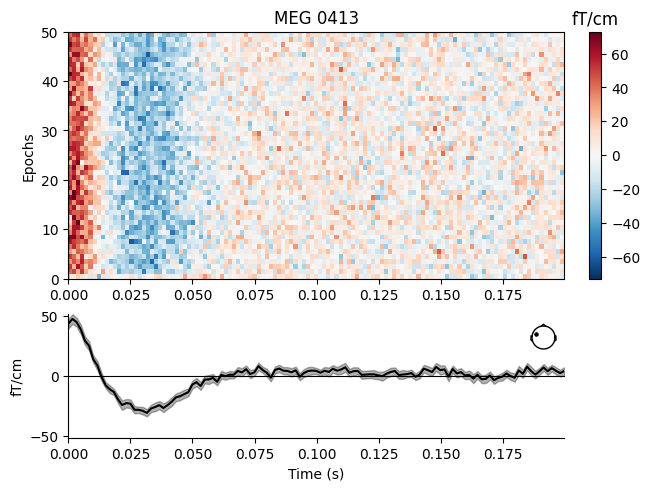

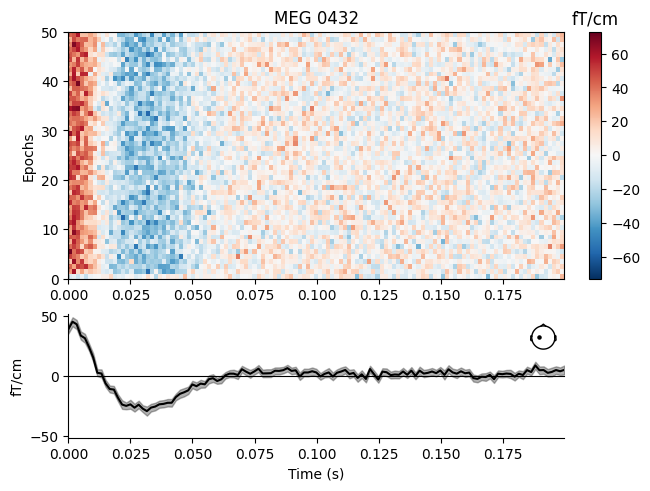

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [19]:
epochs.plot_image(picks=["MEG 0413", "MEG 0432"])

# Small SNR

In [13]:
# # Simulation parameters
# n_events = 50
# events = np.zeros((n_events, 3), int)
# events[:, 0] = 200 * np.arange(n_events)
# events[:, 2] = 1
# snrs_small = np.linspace(0.01, 0.1, 10)

In [14]:
# # Create directory to store simulated data
# output_dir = "simulated_data"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Dictionaries to store results
# results_snr_rle_cortex_small = {snr: [] for snr in snrs_small}
# std_snr_cortex_small = {snr: [] for snr in snrs_small}
# results_snr_rle_custom_cortex_small = {snr: [] for snr in snrs_small}
# mean_signals_snr_cortex_small = {snr: [] for snr in snrs_small}

# pv.set_plot_theme(themes.DocumentTheme())

In [15]:
# for snr in snrs_small:
#     source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    
#     # Добавляем всплески в случайные ROI
#     for _ in range(n_events):
#         random_roi = np.random.choice(["caudalmiddlefrontal-lh", "middletemporal-lh"])
#         random_label = mne.read_labels_from_annot(subject, regexp=random_roi, subjects_dir=subjects_dir)[0]
#         source_simulator.add_data(random_label, source_time_series, events)
    
#     # Симулируем raw данные
#     raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
#     raw = raw.pick_types(meg=True, eeg=False, stim=True, exclude='bads')
#     cov = mne.make_ad_hoc_cov(raw.info)

#     # Добавляем шум и создаем эпохи
#     raw_with_noise = add_noise_with_snr(raw, snr, random_state=random_state)
#     epochs = mne.Epochs(raw_with_noise, events, 1, tmin=0, tmax=0.2, baseline=None)
#     evoked = epochs.average()

#     # Создаем инверсионный оператор и оцениваем источник
#     inv_method = "sLORETA"
#     lambda2 = 1.0 / snr**2
#     inverse_operator = make_inverse_operator(evoked.info, fwd, cov, loose="auto", depth=0.8, fixed=True)

#     # Генерируем случайную 'истинную' оценку источника
#     stc_true = mne.SourceEstimate(
#         np.random.rand(len(src[0]['vertno']) + len(src[1]['vertno']), len(evoked.times)),
#         vertices=[src[i]['vertno'] for i in range(len(src))],
#         tmin=0, tstep=1.0 / info["sfreq"]
#     )

#     # Применяем инверсионное решение для оценки местоположений источников
#     stc_est = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
    
#     # Инициализация ключей словарей для snr, если их еще нет
#     if snr not in results_snr_rle_cortex_small:
#         results_snr_rle_cortex_small[snr] = []
#     if snr not in results_snr_rle_custom_cortex_small:
#         results_snr_rle_custom_cortex_small[snr] = []
#     if snr not in std_snr_cortex_small:
#         std_snr_cortex_small[snr] = []
#     if snr not in mean_signals_snr_cortex_small:
#         mean_signals_snr_cortex_small[snr] = []

#     # Compute Region Localization Error (RLE)
#     try:
#         rle = region_localization_error(stc_true, stc_est, src, per_sample=False)
#         rle_mm = 1 / rle 
#         results_snr_rle_cortex_small[snr].append(rle_mm)
#     except Exception as e:
#         print(f"Error calculating RLE at SNR={snr}: {e}")
#         results_snr_rle_cortex_small[snr].append(np.nan)
        
#     try:
#         true_coords_lh = stc_true.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         true_coords_rh = stc_true.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)
#         est_coords_lh = stc_est.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         est_coords_rh = stc_est.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)

#         # Евклидово расстояние для каждого полушария
#         distance_lh = euclidean(true_coords_lh, est_coords_lh)
#         distance_rh = euclidean(true_coords_rh, est_coords_rh)

#         # Средняя ошибка локализации
#         rle_custom_mm = np.mean([distance_lh, distance_rh])
#         results_snr_rle_custom_cortex_small[snr].append(rle_custom_mm)
        
#         print(f"SNR={snr}: LH Distance={distance_lh:.2f} mm, RH Distance={distance_rh:.2f} mm, Average Custom RLE={rle_custom_mm:.2f} mm")
    
#     except ValueError as e:
#         print(f"Error calculating custom RLE at SNR={snr}: {e}")
#         results_snr_rle_custom_cortex_small[snr].append(np.nan)

#     std_signal = np.std(evoked.data, axis=0)
#     std_snr_cortex_small[snr] = std_signal
#     mean_signal = np.mean(evoked.data, axis=0)
#     mean_signals_snr_cortex_small[snr] = mean_signal

#     # Сохранение данных
#     file_name = f"{output_dir}/simulated_cortex_SNR_{snr:.1f}.fif"
#     raw_with_noise.save(file_name, overwrite=True)
    
#     # Визуализация максимальной амплитуды
#     plot_max_amplitude(stc_est, subject, subjects_dir)


# #     # Визуализируем истинные источники
# #     stc_true.plot(subject=subject, subjects_dir=subjects_dir, title=f'True Source for SNR={snr}', hemi='both', initial_time=0, time_viewer=True)

# #     # Визуализируем оцененные источники
# #     stc_est.plot(subject=subject, subjects_dir=subjects_dir, title=f'Estimated Source for SNR={snr}', 
# #                  hemi='both', views='lateral', smoothing_steps=5, time_viewer=True)

# #     # Вычисляем центр масс и расстояние
# #     try:
# #         # Вычисляем центр масс для каждого полушария
# #         true_coords_lh = stc_true.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
# #         true_coords_rh = stc_true.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)
# #         est_coords_lh = stc_est.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
# #         est_coords_rh = stc_est.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)

# #         # Вычисляем евклидово расстояние для каждого полушария
# #         distance_lh = euclidean(true_coords_lh, est_coords_lh)
# #         distance_rh = euclidean(true_coords_rh, est_coords_rh)

# #         print(f"SNR={snr}: LH True Source={true_coords_lh}, LH Estimated Source={est_coords_lh}, LH Distance={distance_lh:.2f} mm")
# #         print(f"SNR={snr}: RH True Source={true_coords_rh}, RH Estimated Source={est_coords_rh}, RH Distance={distance_rh:.2f} mm")

# #     except ValueError as e:
# #         print(f"Error calculating center of mass: {e}")

In [16]:
# # Save RLE metrics to CSV
# metrics_data = [{'SNR': snr, 
#                  'RLE': np.mean(results_snr_rle_cortex_small[snr]), 
#                  'RLE Custom': np.mean(results_snr_rle_custom_cortex_small[snr])} 
#                 for snr in snrs_small]
# df_metrics = pd.DataFrame(metrics_data)
# df_metrics.to_csv(f"{output_dir}/metrics_cortex_results_rle_smallSNR.csv", index=False)

# # Calculate Standard Error (SE)
# se_rle = {snr: np.std(results_snr_rle_cortex_small[snr]) / np.sqrt(len(results_snr_rle_cortex_small[snr])) for snr in snrs_small}

In [17]:
# np.mean(results_snr_rle_cortex_small[snr])

In [18]:
# results_snr_rle_custom_cortex_small

In [19]:
# # Plot mean signal for different SNRs
# fig, ax = plt.subplots(figsize=(10, 6))
# for snr in snrs_small:
#     ax.plot(mean_signals_snr_cortex_small[snr], label=f"SNR={snr:.2f}")
# ax.set_title('Mean Signal with Different Small SNRs')
# ax.set_ylabel('Amplitude')
# ax.set_xlabel('Time (s)')
# ax.legend()
# ax.grid(True)
# plt.savefig('mean_signal_vs_snr.png')
# plt.show()

In [20]:
# # Plot RLE vs SNR with SE
# fig, ax = plt.subplots(figsize=(10, 6))
# rle_means = [np.mean(results_snr_rle_cortex_small[snr]) for snr in snrs_small]
# rle_se = [se_rle[snr] for snr in snrs_small]
# ax.errorbar(snrs_small, rle_means, yerr=rle_se, fmt='-o', capsize=5)
# ax.set_title('Region Localization Error (RLE) vs Small SNR for caudalmiddlefrontal and middletemporal region')
# ax.set_ylabel('RLE (mm)')
# ax.set_xlabel('SNR')
# ax.grid(True)
# plt.savefig('rle_vs_snr_with_se.png')
# plt.show()

In [21]:
# plot_violin_plot(std_snr_cortex_small)

# Volume Signal Simmulator

In [ ]:
random_state = 42

data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"
evoked_fname = data_path / "MEG" / subject / "sample_audvis-ave.fif"
info = mne.io.read_info(evoked_fname)
tstep = 1.0 / info["sfreq"]

fwd_fname = data_path / "MEG" / subject / "sample_audvis-meg-eeg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]


roi_labels = [
     "parahippocampal-lh"
]

spike_data = scipy.io.loadmat('spike.mat')
source_time_series = spike_data['spike'].squeeze()


In [ ]:
# Simulation parameters
n_events = 50
events = np.zeros((n_events, 3), int)
events[:, 0] = 200 * np.arange(n_events)
events[:, 2] = 1
snrs = np.linspace(0.02, 1.0, 5)

# Function to add noise with specified SNR
def add_noise_with_snr(raw, snr, random_state=None):
    raw_with_noise = raw.copy()
    data, _ = raw_with_noise[:]
    rms_signal = np.sqrt(np.mean(data ** 2, axis=1))
    np.random.seed(random_state)
    noise = np.random.normal(0, 1, data.shape)
    rms_noise = np.sqrt(np.mean(noise ** 2, axis=1))
    scaling_factor = rms_signal / (snr * rms_noise)
    noise = noise * scaling_factor[:, np.newaxis]
    data_with_noise = data + noise
    raw_with_noise._data = data_with_noise
    return raw_with_noise

def plot_violin_plot(std_dict):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=list(std_dict.values()), inner="point", ax=ax)
    ax.set_xticks(np.arange(len(std_dict)))
    ax.set_xticklabels([f"SNR={snr:.2f}" for snr in std_dict.keys()])
    ax.set_title("Violin Plot of Standard Deviation for Each SNR")
    ax.set_ylabel("Standard Deviation")
    plt.savefig('violin_plot_std.png')
    plt.show()

def plot_max_amplitude(stc_est, subject, subjects_dir):
    max_amp = np.max(stc_est.data)
    stc_est.plot(
        subject=subject, 
        subjects_dir=subjects_dir, 
        hemi='both', 
        initial_time=0, 
        time_viewer=True, 
        colormap="hot", 
        clim=dict(kind='value', pos_lims=[0, max_amp*0.5, max_amp])
    )


In [77]:
# Create directory to store simulated data
output_dir = "simulated_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dictionaries to store results
snrs = np.linspace(0.01, 1.0, 5)
results_snr_rle_volume = {snr: [] for snr in snrs}
std_snr_volume = {snr: [] for snr in snrs}
results_snr_rle_custom_volume = {snr: [] for snr in snrs}
mean_signals_snr_volume = {snr: [] for snr in snrs}

results_df_volume = pd.DataFrame(columns=['SNR', 'RLE_Score', 'Mean_Signal'])

pv.set_plot_theme(themes.DocumentTheme())

In [78]:
for snr in snrs:
    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    
    # Добавляем всплески в случайные ROI
    for _ in range(n_events):
        random_roi = np.random.choice(roi_labels)
        random_label = mne.read_labels_from_annot(subject, regexp=random_roi, subjects_dir=subjects_dir)[0]
        source_simulator.add_data(random_label, source_time_series, events)

    
    # Симулируем raw данные
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
    raw = raw.pick_types(meg=True, eeg=False, stim=True, exclude='bads')
    cov = mne.make_ad_hoc_cov(raw.info)

    # Добавляем шум и создаем эпохи
    raw_with_noise = add_noise_with_snr(raw, snr, random_state=random_state)
    epochs = mne.Epochs(raw_with_noise, events, 1, tmin=0, tmax=0.2, baseline=None)
    evoked = epochs.average()

    # Создаем инверсионный оператор и оцениваем источник
    inv_method = "sLORETA"
    lambda2 = 1.0 / snr**2
    inverse_operator = make_inverse_operator(evoked.info, fwd, cov, loose="auto", depth=0.8, fixed=True)

    # Генерируем случайную 'истинную' оценку источника
    stc_true = mne.SourceEstimate(
        np.random.rand(len(src[0]['vertno']) + len(src[1]['vertno']), len(evoked.times)),
        vertices=[src[i]['vertno'] for i in range(len(src))],
        tmin=0, tstep=1.0 / info["sfreq"]
    )

    # Применяем инверсионное решение для оценки местоположений источников
    stc_est = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
    
    score_value = 1/(region_localization_error(stc_true, stc_est, src, per_sample=False))
    results_snr_rle_volume[snr].append(score_value)
    
    # Compute custom Region Localization Error (RLE) using our function
    try:
        rle_custom_mm = custom_localization_error(stc_true, stc_est, subject, subjects_dir)
        results_snr_rle_custom_volume[snr].append(rle_custom_mm)
        
        print(f"SNR={snr}: Average Custom RLE={rle_custom_mm:.2f} mm")
    
    except ValueError as e:
        print(f"Error calculating custom RLE at SNR={snr}: {e}")
        results_snr_rle_custom_volume[snr].append(np.nan)

    std_signal = np.std(evoked.data, axis=0)
    std_snr_volume[snr] = std_signal
    
    mean_signal = np.mean(evoked.data, axis=0)
    mean_signals_snr_volume[snr] = mean_signal

    # Save the noisy data for each SNR
    file_name = f"{output_dir}/simulated_volume_SNR_{snr:.1f}.fif"
    raw_with_noise.save(file_name, overwrite=True)

    # Max amp visualisation
    plot_max_amplitude(stc_est, subject, subjects_dir)
    
#         # Визуализируем истинные источники
#     stc_true.plot(subject=subject, subjects_dir=subjects_dir, title=f'True Source for SNR={snr}', hemi='both', initial_time=0, time_viewer=True)

#     # Визуализируем оцененные источники
#     stc_est.plot(subject=subject, subjects_dir=subjects_dir, title=f'Estimated Source for SNR={snr}', 
#                  hemi='both', views='lateral', smoothing_steps=5, time_viewer=True)

#     # Вычисляем центр масс и расстояние
#     try:
#         # Вычисляем центр масс для каждого полушария
#         true_coords_lh = stc_true.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         true_coords_rh = stc_true.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)
#         est_coords_lh = stc_est.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
#         est_coords_rh = stc_est.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)

#         # Вычисляем евклидово расстояние для каждого полушария
#         distance_lh = euclidean(true_coords_lh, est_coords_lh)
#         distance_rh = euclidean(true_coords_rh, est_coords_rh)

#         print(f"SNR={snr}: LH True Source={true_coords_lh}, LH Estimated Source={est_coords_lh}, LH Distance={distance_lh:.2f} mm")
#         print(f"SNR={snr}: RH True Source={true_coords_rh}, RH Estimated Source={est_coords_rh}, RH Distance={distance_rh:.2f} mm")

#     except ValueError as e:
#         print(f"Error calculating center of mass: {e}")

Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_12113/1708149568.py:69: RuntimeWarning: This filename (/Users/diana/Documents/snr_sim/simulated_data/simulated_volume_SNR_0.0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Using pyvistaqt 3d backend.


2025-03-17 13:28:05.424 python[12113:633111] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-17 13:28:05.424 python[12113:633111] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_12113/1708149568.py:69: RuntimeWarning: This filename (/Users/diana/Documents/snr_sim/simulated_data/simulated_volume_SNR_0.3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_with_noise.save(file_name, overwrite=True)


Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/

KeyboardInterrupt: 

In [16]:
# Save RLE metrics to CSV
metrics_data = [{'SNR': snr, 'RLE': np.mean(results_snr_rle_volume[snr]), 'RLE CUstome': np.mean(results_snr_rle_custom_volume[snr])} for snr in snrs]
df_metrics = pd.DataFrame(metrics_data)
df_metrics.to_csv( f"{output_dir}/metrics_volume_results_rle.csv", index=False)

# Calculate Standard Error (SE)
se_rle = {snr: np.std(results_snr_rle_volume[snr]) / np.sqrt(len(results_snr_rle_volume[snr])) for snr in snrs}

In [17]:
results_snr_rle_volume

{0.01: [33.60087979516474, 33.60087979516474],
 0.2575: [38.096577085867104],
 0.505: [37.79243424468756],
 0.7525: [37.818784334910724],
 1.0: [36.60885598214257]}

In [18]:
# Plot RLE vs SNR with SE
fig, ax = plt.subplots(figsize=(10, 6))
rle_means = [np.mean(results_snr_rle_volume[snr]) for snr in snrs]
rle_se = [se_rle[snr] for snr in snrs]
ax.errorbar(snrs, rle_means, yerr=rle_se, fmt='-o', capsize=5)
ax.set_title('Region Localization Error (RLE) vs SNR for Parahippocampal Vol')
ax.set_ylabel('RLE (mm)')
ax.set_xlabel('SNR')
ax.grid(True)
plt.savefig('rle_vs_snr_with_se.png')
plt.show()

In [19]:
# Plot RLE vs SNR with SE
fig, ax = plt.subplots(figsize=(10, 6))
rle_means = [np.mean(results_snr_rle_custom_volume[snr]) for snr in snrs]
rle_se = [se_rle[snr] for snr in snrs]
ax.errorbar(snrs, rle_means, yerr=rle_se, fmt='-o', capsize=5)
ax.set_title('Region Localization Error (RLE) vs SNR for Parahippocampal Vol')
ax.set_ylabel('RLE (mm)')
ax.set_xlabel('SNR')
ax.grid(True)
plt.savefig('rle_vs_snr_with_se.png')
plt.show()

In [20]:
# Plot mean signal for different SNRs
fig, ax = plt.subplots(figsize=(10, 6))
for snr in snrs:
    ax.plot(mean_signals_snr_volume[snr], label=f"SNR={snr:.2f}")
ax.set_title('Mean Signal with Different SNRs')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.legend()
ax.grid(True)
plt.savefig('mean_signal_vs_snr.png')
plt.show()

In [22]:
def visualize_raw_data(file_name, stim_channel='STI 014'):
    """
    Visualizes raw MEG data and events with scaling adjustments.
    
    Parameters:
    - file_name: path to the .fif file
    - stim_channel: name of the stimulus channel
    """
    raw = mne.io.read_raw_fif(file_name, preload=True)
    
    print(f"File: {file_name}")
    print("Sampling frequency:", raw.info['sfreq'])
    print("Duration (seconds):", raw.times[-1])
    
    # Output stimulus information
    if stim_channel in raw.ch_names:
        events = mne.find_events(raw, stim_channel=stim_channel, shortest_event=1)
        print(f"Number of events: {len(events)}")
        print("Events (index, trigger, duration):")
   
    raw.plot(n_channels=30, scalings=dict(mag=1e-2), title='Raw MEG Data', show=True)

In [ ]:
# Example usage of the function
snrs = np.linspace(0.1, 1.0, 10)
file_names = [f"{output_dir}/simulated_volume_SNR_{snr:.1f}.fif" for snr in snrs]

for file_name in file_names:
    visualize_raw_data(file_name)

In [23]:
epochs.plot_image(picks=["MEG 0412", "MEG 0432"])

Using data from preloaded Raw for 50 events and 121 original time points ...
0 bad epochs dropped
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 1280x960 with 4 Axes>, <Figure size 1280x960 with 4 Axes>]

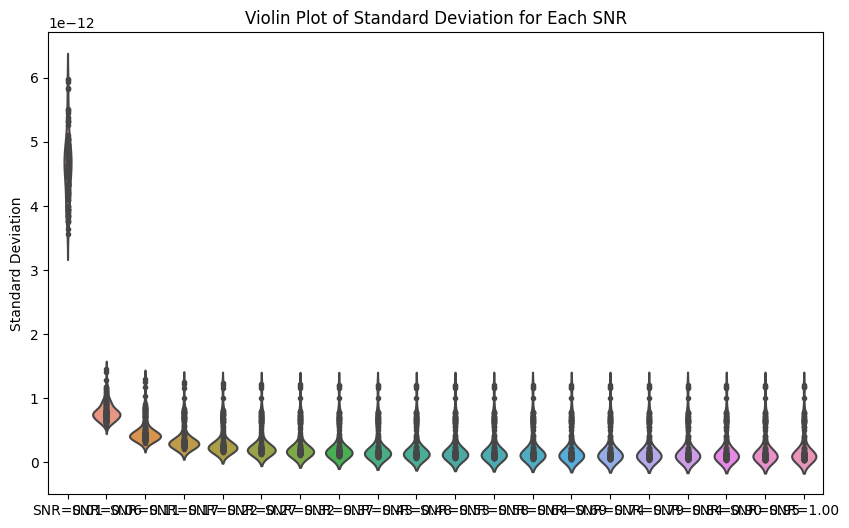

In [33]:
plot_violin_plot(std_snr_volume)

# Small Volume SNR

In [34]:
# random_state = 42

# data_path = sample.data_path()
# subjects_dir = data_path / "subjects"
# subject = "sample"
# evoked_fname = data_path / "MEG" / subject / "sample_audvis-ave.fif"
# info = mne.io.read_info(evoked_fname)
# tstep = 1.0 / info["sfreq"]

# fwd_fname = data_path / "MEG" / subject / "sample_audvis-meg-eeg-oct-6-fwd.fif"
# fwd = mne.read_forward_solution(fwd_fname)
# src = fwd["src"]

# roi_labels = [
#      "parahippocampal-lh"
# ]

# spike_data = scipy.io.loadmat('spike.mat')
# source_time_series = spike_data['spike'].squeeze()

In [35]:
# # Simulation parameters
# n_events = 50
# events = np.zeros((n_events, 3), int)
# events[:, 0] = 200 * np.arange(n_events)
# events[:, 2] = 1
# snrs_small = np.linspace(0.01, 0.1, 10)

# # Function to add noise with specified SNR
# def add_noise_with_snr(raw, snr, random_state=None):
#     raw_with_noise = raw.copy()
#     data, _ = raw_with_noise[:]
#     rms_signal = np.sqrt(np.mean(data ** 2, axis=1))
#     np.random.seed(random_state)
#     noise = np.random.normal(0, 1, data.shape)
#     rms_noise = np.sqrt(np.mean(noise ** 2, axis=1))
#     scaling_factor = rms_signal / (snr * rms_noise)
#     noise = noise * scaling_factor[:, np.newaxis]
#     data_with_noise = data + noise
#     raw_with_noise._data = data_with_noise
#     return raw_with_noise

# def plot_violin_plot(std_dict):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.violinplot(data=list(std_dict.values()), inner="point", ax=ax)
#     ax.set_xticks(np.arange(len(std_dict)))
#     ax.set_xticklabels([f"SNR={snr:.2f}" for snr in std_dict.keys()])
#     ax.set_title("Violin Plot of Standard Deviation for Each SNR")
#     ax.set_ylabel("Standard Deviation")
#     plt.savefig('violin_plot_std.png')
#     plt.show()

# def plot_max_amplitude(stc_est, subject, subjects_dir):
#     max_amp = np.max(stc_est.data)
#     stc_est.plot(
#         subject=subject, 
#         subjects_dir=subjects_dir, 
#         hemi='both', 
#         initial_time=0, 
#         time_viewer=True, 
#         colormap="hot", 
#         clim=dict(kind='value', pos_lims=[0, max_amp*0.5, max_amp])
#     )


In [36]:
# # Create directory to store simulated data
# output_dir = "simulated_data"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Dictionaries to store results
# results_snr_rle_volume_small = {snr: [] for snr in snrs_small}
# std_snr_volume_small = {snr: [] for snr in snrs_small}
# results_snr_rle_custom_volume_small = {snr: [] for snr in snrs_small}
# mean_signals_snr_volume_small = {snr: [] for snr in snrs_small}

# pv.set_plot_theme(themes.DocumentTheme())

In [37]:
# for snr in snrs_small:
#     source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    
#     # Добавляем всплески в случайные ROI
#     for _ in range(n_events):
#         random_roi = np.random.choice(["parahippocampal-lh"])
#         random_label = mne.read_labels_from_annot(subject, regexp=random_roi, subjects_dir=subjects_dir)[0]
#         source_simulator.add_data(random_label, source_time_series, events)
    
#     # Симулируем raw данные
#     raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
#     raw = raw.pick_types(meg=True, eeg=False, stim=True, exclude='bads')
#     cov = mne.make_ad_hoc_cov(raw.info)

#     # Добавляем шум и создаем эпохи
#     raw_with_noise = add_noise_with_snr(raw, snr, random_state=random_state)
#     epochs = mne.Epochs(raw_with_noise, events, 1, tmin=0, tmax=0.2, baseline=None)
#     evoked = epochs.average()

#     # Создаем инверсионный оператор и оцениваем источник
#     inv_method = "sLORETA"
#     lambda2 = 1.0 / snr**2
#     inverse_operator = make_inverse_operator(evoked.info, fwd, cov, loose="auto", depth=0.8, fixed=True)

#     # Генерируем случайную 'истинную' оценку источника
#     stc_true = mne.SourceEstimate(
#         np.random.rand(len(src[0]['vertno']) + len(src[1]['vertno']), len(evoked.times)),
#         vertices=[src[i]['vertno'] for i in range(len(src))],
#         tmin=0, tstep=1.0 / info["sfreq"]
#     )

#     # Применяем инверсионное решение для оценки местоположений источников
#     stc_est = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
    
#     score_value = 1/(region_localization_error(stc_true, stc_est, src, per_sample=False))
#     results_snr_rle_volume_small[snr].append(score_value)

#     std_signal = np.std(evoked.data, axis=0)
#     std_snr_volume_small[snr] = std_signal
    
#     mean_signal = np.mean(evoked.data, axis=0)
#     mean_signals_snr_volume_small[snr] = mean_signal

#     # Save the noisy data for each SNR
#     file_name = f"{output_dir}/simulated_volume_SmallSNR_{snr:.1f}.fif"
#     raw_with_noise.save(file_name, overwrite=True)

#     # Max amp visualisation
#     plot_max_amplitude(stc_est, subject, subjects_dir)
    
# #         # Визуализируем истинные источники
# #     stc_true.plot(subject=subject, subjects_dir=subjects_dir, title=f'True Source for SNR={snr}', hemi='both', initial_time=0, time_viewer=True)

# #     # Визуализируем оцененные источники
# #     stc_est.plot(subject=subject, subjects_dir=subjects_dir, title=f'Estimated Source for SNR={snr}', 
# #                  hemi='both', views='lateral', smoothing_steps=5, time_viewer=True)

# #     # Вычисляем центр масс и расстояние
# #     try:
# #         # Вычисляем центр масс для каждого полушария
# #         true_coords_lh = stc_true.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
# #         true_coords_rh = stc_true.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)
# #         est_coords_lh = stc_est.center_of_mass(subject=subject, hemi='lh', subjects_dir=subjects_dir)
# #         est_coords_rh = stc_est.center_of_mass(subject=subject, hemi='rh', subjects_dir=subjects_dir)

# #         # Вычисляем евклидово расстояние для каждого полушария
# #         distance_lh = euclidean(true_coords_lh, est_coords_lh)
# #         distance_rh = euclidean(true_coords_rh, est_coords_rh)

# #         print(f"SNR={snr}: LH True Source={true_coords_lh}, LH Estimated Source={est_coords_lh}, LH Distance={distance_lh:.2f} mm")
# #         print(f"SNR={snr}: RH True Source={true_coords_rh}, RH Estimated Source={est_coords_rh}, RH Distance={distance_rh:.2f} mm")

# #     except ValueError as e:
# #         print(f"Error calculating center of mass: {e}")

In [38]:
# # Save RLE metrics to CSV
# metrics_data = [{'SNR': snr, 'RLE': np.mean(results_snr_rle_volume_small[snr])} for snr in snrs_small]
# df_metrics = pd.DataFrame(metrics_data)
# df_metrics.to_csv( f"{output_dir}/metrics_volume_results_rle_smallSNR.csv", index=False)

# # Calculate Standard Error (SE)
# se_rle = {snr: np.std(results_snr_rle_volume_small[snr]) / np.sqrt(len(results_snr_rle_volume_small[snr])) for snr in snrs_small}

In [39]:
# results_snr_rle_volume_small

In [40]:
# # Plot RLE vs SNR with SE
# fig, ax = plt.subplots(figsize=(10, 6))
# rle_means = [np.mean(results_snr_rle_volume_small[snr]) for snr in snrs_small]
# rle_se = [se_rle[snr] for snr in snrs_small]
# ax.errorbar(snrs_small, rle_means, yerr=rle_se, fmt='-o', capsize=5)
# ax.set_title('Region Localization Error (RLE) vs SNR for Parahippocampal Vol')
# ax.set_ylabel('RLE (mm)')
# ax.set_xlabel('SNR')
# ax.grid(True)
# plt.savefig('rle_vs_snr_with_se.png')
# plt.show()

In [41]:
# # Plot mean signal for different SNRs
# fig, ax = plt.subplots(figsize=(10, 6))
# for snr in snrs_small:
#     ax.plot(mean_signals_snr_volume_small[snr], label=f"SNR={snr:.2f}")
# ax.set_title('Mean Signal with Different SNRs')
# ax.set_ylabel('Amplitude')
# ax.set_xlabel('Time (s)')
# ax.legend()
# ax.grid(True)
# plt.savefig('mean_signal_vs_snr.png')
# plt.show()

In [42]:
# plot_violin_plot(std_snr_volume_small)

# Mixed space

In [8]:
random_state = 42

# dir
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"
data_dir = data_path / "MEG" / subject
bem_dir = subjects_dir / subject / "bem"

# evoked
evoked_fname = data_path / "MEG" / subject / "sample_audvis-ave.fif"
info = mne.io.read_info(evoked_fname)
tstep = 1.0 / info["sfreq"]


# file names for the mixed space
fname_mixed_src = bem_dir / f"{subject}-oct-6-mixed-src.fif"
fname_aseg = subjects_dir / subject / "mri" / "aseg.mgz"

fname_model = bem_dir / f"{subject}-5120-bem.fif"
fname_bem = bem_dir / f"{subject}-5120-bem-sol.fif"

fname_evoked = data_dir / f"{subject}_audvis-ave.fif"
fname_trans = data_dir / f"{subject}_audvis_raw-trans.fif"
fname_fwd = data_dir / f"{subject}_audvis-meg-oct-6-mixed-fwd.fif"
fname_cov = data_dir / f"{subject}_audvis-shrunk-cov.fif"

spike_data = scipy.io.loadmat('spike.mat')
source_time_series = spike_data['spike'].squeeze()

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active


In [9]:
info

<Info | 14 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on, Average EEG reference: on
 sfreq: 600.6 Hz
>

In [10]:
labels_vol = [
    "Left-Hippocampus"
]

roi_labels = ["parahippocampal-lh", "parahippocampal-rh", "Left-Hippocampus"]

In [11]:
src = mne.setup_source_space(
    subject, spacing="oct5", add_dist=False, subjects_dir=subjects_dir
)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/diana/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 1026/155407 selected to source space (oct = 5)

Loading /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/diana/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 1026/156866 selected to sourc

In [16]:
vol_src = mne.setup_volume_source_space(
    subject,
    mri=fname_aseg,
    pos=10.0,
    bem=fname_model,
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : /Users/diana/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz

Reading /Users/diana/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...

Loaded inner skull from /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem.fif (2562 nodes)
Surface CM = (   0.7  -10.0   44.3) mm
Surface fits inside a sphere with radius   91.8 mm
Surface extent:
    x =  -66.7 ...   68.8 mm
    y =  -88.0 ...   79.0 mm
    z =  -44.5 ...  105.8 mm
Grid extent:
    x =  -70.0 ...   70.0 mm
    y =  -90.0 ...   80.0 mm
    z =  -50.0 ...  110.0 mm
4590 sources before omitting any.
2961 sources after omitting infeasible sources not within 0.0 - 91.8 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface i

In [25]:
vol_src[0]

{'np': 4590,
 'nn': array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]),
 'rr': array([[-0.07, -0.09, -0.05],
        [-0.06, -0.09, -0.05],
        [-0.05, -0.09, -0.05],
        ...,
        [ 0.05,  0.08,  0.11],
        [ 0.06,  0.08,  0.11],
        [ 0.07,  0.08,  0.11]]),
 'inuse': array([False, False, False, ..., False, False, False]),
 'type': 'vol',
 'nuse': 3,
 'coord_frame': 5 (FIFFV_COORD_MRI),
 'id': -1 (FIFFV_MNE_SURF_UNKNOWN),
 'shape': (15, 18, 17),
 'vertno': array([1775, 2029, 2030]),
 'seg_name': 'Left-Hippocampus',
 'mri_file': PosixPath('/Users/diana/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz'),
 'neighbor_vert': array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]),
 'src

In [12]:
import matplotlib.pyplot as plt
from nilearn import plotting

In [14]:
fwd = mne.make_forward_solution(
    fname_evoked,
    fname_trans,
    src,
    fname_bem,
    mindist=5.0,  # ignore sources<=5mm from innerskull
    meg=True,
    eeg=False,
    n_jobs=None,
)

leadfield = fwd["sol"]["data"]
ns, nd = leadfield.shape
print(f"Leadfield size : {ns} sensors x {nd} dipoles")
print(
    f"The fwd source space contains {len(fwd['src'])} spaces and "
    f"{sum(s['nuse'] for s in fwd['src'])} vertices"
)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=1026>, <surface (rh), n_vertices=156866, n_used=1026>] MRI (surface RAS) coords, subject 'sample', ~23.9 MB>
MRI -> head transform : /Users/diana/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis-ave.fif
Conductor model   : /Users/diana/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 2052 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999310 0.009985 -0.035787      -3.17 mm
    0.012759 0.812405 0.582954       6.86 mm
    0.034894 -0.583008 0.811716      28.88 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991420 -0.039936 -0.124467      -6.13 mm
    0.060661 0.984012 0.1

In [28]:
fwd["src"]

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=942>, <surface (rh), n_vertices=156866, n_used=942>] head coords, subject 'sample', ~23.9 MB>

In [12]:
# Simulation parameters
n_events = 5
events = np.zeros((n_events, 3), int)
events[:, 0] = 200 * np.arange(n_events)
events[:, 2] = 1
snrs = np.linspace(0.02, 1.0, 5)

# Function to add noise with specified SNR
def add_noise_with_snr(raw, snr, random_state=None):
    raw_with_noise = raw.copy()
    data, _ = raw_with_noise[:]
    rms_signal = np.sqrt(np.mean(data ** 2, axis=1))
    np.random.seed(random_state)
    noise = np.random.normal(0, 1, data.shape)
    rms_noise = np.sqrt(np.mean(noise ** 2, axis=1))
    scaling_factor = rms_signal / (snr * rms_noise)
    noise = noise * scaling_factor[:, np.newaxis]
    data_with_noise = data + noise
    raw_with_noise._data = data_with_noise
    return raw_with_noise

def plot_violin_plot(std_dict):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=list(std_dict.values()), inner="point", ax=ax)
    ax.set_xticks(np.arange(len(std_dict)))
    ax.set_xticklabels([f"SNR={snr:.2f}" for snr in std_dict.keys()])
    ax.set_title("Violin Plot of Standard Deviation for Each SNR")
    ax.set_ylabel("Standard Deviation")
    plt.savefig('violin_plot_std.png')
    plt.show()

def plot_max_amplitude(stc_est, subject, subjects_dir):
    max_amp = np.max(stc_est.data)
    stc_est.plot(
        subject=subject, 
        subjects_dir=subjects_dir, 
        hemi='both', 
        initial_time=0, 
        time_viewer=True, 
        colormap="hot", 
        clim=dict(kind='value', pos_lims=[0, max_amp*0.5, max_amp])
    )

In [13]:
# Create directory to store simulated data
output_dir = "simulated_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dictionaries to store results
snrs = np.linspace(0.01, 1.0, 5)
results_snr_rle_volume = {snr: [] for snr in snrs}
std_snr_volume = {snr: [] for snr in snrs}
results_snr_rle_custom_volume = {snr: [] for snr in snrs}
mean_signals_snr_volume = {snr: [] for snr in snrs}

results_df_volume = pd.DataFrame(columns=['SNR', 'RLE_Score', 'Mean_Signal'])

pv.set_plot_theme(themes.DocumentTheme())

In [14]:
events

array([[  0,   0,   1],
       [200,   0,   1],
       [400,   0,   1],
       [600,   0,   1],
       [800,   0,   1]])

In [15]:
len(snrs)

5

In [34]:
src = fwd["src"]

In [31]:
roi_labels = ['parahippocampal-lh', 'parahippocampal-rh']

In [21]:
subcortical_labels = mne.get_volume_labels_from_src(
    src,
    subject, 
    subjects_dir=subjects_dir
)

In [31]:
type(subcortical_labels)

list

In [22]:
subcortical_labels

[<Label | sample, 'Hippocampus-lh', lh : 3 vertices>]

In [27]:
for lab in subcortical_labels:
    print(lab)
    print(len(lab.vertices))

<Label | sample, 'Hippocampus-lh', lh : 3 vertices>
3


In [30]:
type(all_labels)

list

In [29]:
all_labels = mne.read_labels_from_annot(subject, subjects_dir=subjects_dir)
all_labels

Reading labels from parcellation...
   read 34 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot


[<Label | sample, 'bankssts-lh', lh : 1604 vertices>,
 <Label | sample, 'bankssts-rh', rh : 1555 vertices>,
 <Label | sample, 'caudalanteriorcingulate-lh', lh : 1277 vertices>,
 <Label | sample, 'caudalanteriorcingulate-rh', rh : 1982 vertices>,
 <Label | sample, 'caudalmiddlefrontal-lh', lh : 3810 vertices>,
 <Label | sample, 'caudalmiddlefrontal-rh', rh : 3994 vertices>,
 <Label | sample, 'cuneus-lh', lh : 2545 vertices>,
 <Label | sample, 'cuneus-rh', rh : 2479 vertices>,
 <Label | sample, 'entorhinal-lh', lh : 726 vertices>,
 <Label | sample, 'entorhinal-rh', rh : 571 vertices>,
 <Label | sample, 'frontalpole-lh', lh : 350 vertices>,
 <Label | sample, 'frontalpole-rh', rh : 483 vertices>,
 <Label | sample, 'fusiform-lh', lh : 5209 vertices>,
 <Label | sample, 'fusiform-rh', rh : 4843 vertices>,
 <Label | sample, 'inferiorparietal-lh', lh : 7839 vertices>,
 <Label | sample, 'inferiorparietal-rh', rh : 8562 vertices>,
 <Label | sample, 'inferiortemporal-lh', lh : 6363 vertices>,
 <La

In [55]:
from mne.simulation.raw import _check_stc_iterable, _stc_data_event

In [71]:
# 1. Check that our STC is iterable (or convert it to one using cycle)
# 2. Do first iter so we can get the vertex subselection
# 3. Get the list of verts, which must stay the same across iterations
stc = source_simulator
stc_enum = enumerate(stc)
del stc

try:
    stc_counted = next(stc_enum)
except StopIteration:
    raise RuntimeError("Iterable did not provide stc[0]")
_, _, verts = _stc_data_event(stc_counted, 1, info["sfreq"])

In [72]:
for i, elem in stc_enum:
    print(i, elem)

1 (<SourceEstimate | 25 vertices, subject : sample, tmin : 1664.9601096532322 (ms), tmax : 1996.2871714742257 (ms), tstep : 1.6649601096532323 (ms), data shape : (25, 200), ~40 kB>, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))


In [73]:
stc_idx, stc = stc_counted
if isinstance(stc, list | tuple):
        if len(stc) != 2:
            raise ValueError(f"stc, if tuple, must be length 2, got {len(stc)}")
        stc, stim_data = stc
verts_ = stc.vertices

In [59]:
verts_

[array([  2891,   3837,  64498,  73422,  73434,  75705,  79387,  82010,
         83282,  89533,  89597,  95357, 101281, 105883, 106860]),
 array([66616, 68085, 70427, 78028, 78042, 82069, 86900, 89319, 95320,
        99655])]

In [46]:
stc_enum, stc_counted, verts = _check_stc_iterable(source_simulator, info)

In [49]:
verts

[array([  2891,   3837,  64498,  73422,  73434,  75705,  79387,  82010,
         83282,  89533,  89597,  95357, 101281, 105883, 106860]),
 array([66616, 68085, 70427, 78028, 78042, 82069, 86900, 89319, 95320,
        99655])]

In [ ]:
# verts = [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]

In [43]:
for snr in snrs:
    source_simulator = mne.simulation.SourceSimulator(fwd["src"], tstep=tstep)
    
    for _ in range(n_events):
        # 1. lh and rh
        cort_roi = np.random.choice(["parahippocampal-lh", "parahippocampal-rh"])
        cort_label = mne.read_labels_from_annot(subject, regexp=cort_roi, subjects_dir=subjects_dir)[0]
        print(cort_label)
        source_simulator.add_data(cort_label, source_time_series, events)
        
        # 2. subcortical (hippocampus)
        subcort_label = mne.get_volume_labels_from_src(fwd["src"], subject, subjects_dir)[0]
        print(subcort_label)
        source_simulator.add_data(subcort_label, source_time_series, events)
    
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
    raw = raw.pick_types(meg=True, eeg=False, stim=True, exclude='bads')
    cov = mne.make_ad_hoc_cov(raw.info)

    # Добавляем шум и создаем эпохи
    raw_with_noise = add_noise_with_snr(raw, snr, random_state=random_state)
    epochs = mne.Epochs(raw_with_noise, events, 1, tmin=0, tmax=0.2, baseline=None)
    evoked = epochs.average()

    # inverse operator
    inv_method = "sLORETA"
    lambda2 = 1.0 / snr**2
    loose = dict(surface=0.2, volume=1.0)
    inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, depth=None, loose=loose, verbose=True
    )

    # Генерируем случайную 'истинную' оценку источника
    stc_true = mne.MixedSourceEstimate(
        np.random.rand(len(src[0]['vertno']) + len(src[1]['vertno'] + len(src[2]['vertno'])), len(evoked.times)),
        vertices=[src[i]['vertno'] for i in range(len(src))],
        tmin=0, tstep=1.0 / info["sfreq"]
    )

    # Применяем инверсионное решение для оценки местоположений источников
    stc_est = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
    src = inverse_operator["src"]
    score_value = 1/(region_localization_error(stc_true, stc_est, src, per_sample=False))
    results_snr_rle_volume[snr].append(score_value)
    
    # Compute custom Region Localization Error (RLE) using our function
    try:
        rle_custom_mm = custom_localization_error(stc_true, stc_est, subject, subjects_dir)
        results_snr_rle_custom_volume[snr].append(rle_custom_mm)
        
        print(f"SNR={snr}: Average Custom RLE={rle_custom_mm:.2f} mm")
    
    except ValueError as e:
        print(f"Error calculating custom RLE at SNR={snr}: {e}")
        results_snr_rle_custom_volume[snr].append(np.nan)

    std_signal = np.std(evoked.data, axis=0)
    std_snr_volume[snr] = std_signal
    
    mean_signal = np.mean(evoked.data, axis=0)
    mean_signals_snr_volume[snr] = mean_signal

    # Save the noisy data for each SNR
    file_name = f"{output_dir}/simulated_mixed_SNR_{snr:.1f}.fif"
    raw_with_noise.save(file_name, overwrite=True)

    # Max amp visualisation
    plot_max_amplitude(stc_est, subject, subjects_dir)

Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
<Label | sample, 'parahippocampal-lh', lh : 1434 vertices>
<Label | sample, 'Hippocampus-lh', lh : 3 vertices>
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
<Label | sample, 'parahippocampal-lh', lh : 1434 vertices>
<Label | sample, 'Hippocampus-lh', lh : 3 vertices>
Reading labels from parcellation...
   read 1 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/diana/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
<Label | sample, 'parahippocampal-lh', lh : 1434 vertices>
<Label | sample, 'Hippocampus

RuntimeError: Mismatch between number of source spaces (3) and STC vertices (2)

In [42]:
source_simulator.get_stc()

<SourceEstimate | 25 vertices, subject : sample, tmin : 0.0 (ms), tmax : 1996.2871714742255 (ms), tstep : 1.6649601096532323 (ms), data shape : (25, 1200), ~235 kB>